
# ML Model Implementation — Customer Churn Prediction

**Objective:**  
Train, evaluate, and compare multiple machine learning models for churn prediction using Logistic Regression, Random Forest, and XGBoost.  
This notebook includes model evaluation, hyperparameter tuning, and result logging.
    

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import warnings

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
    

In [ ]:
X_train = pd.read_csv('../data/processed/X_train_res.csv')
y_train = pd.read_csv('../data/processed/y_train_res.csv').values.ravel()
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print("Train:", X_train.shape, "Test:", X_test.shape)
    

Train: (8278, 7072) Test: (1409, 7072)


In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probs)

    print(f"Model: {model.__class__.__name__}")
    print(classification_report(y_test, preds))
    print("ROC-AUC:", round(auc, 4))

    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model.__class__.__name__} — Confusion Matrix")
    plt.savefig(f"../reports/figures/{model.__class__.__name__.lower()}_confusion_matrix.png", dpi=200, bbox_inches='tight')
    plt.show()

    return auc
    

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1035
           1       0.57      0.62      0.59       374

    accuracy                           0.78      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409

ROC-AUC: 0.8317


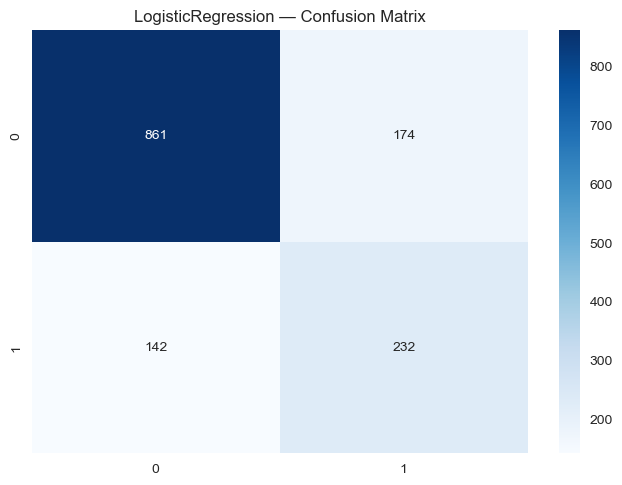

In [ ]:
lr = LogisticRegression(max_iter=1000)
auc_lr = evaluate_model(lr, X_train, y_train, X_test, y_test)
    

Model: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1035
           1       0.61      0.60      0.60       374

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409

ROC-AUC: 0.8344


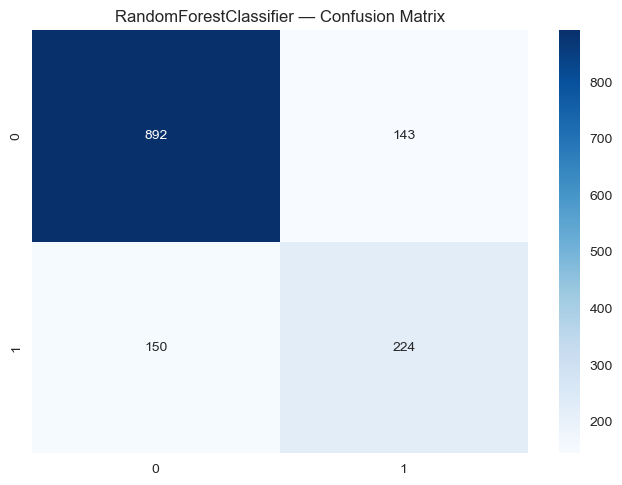

In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
auc_rf = evaluate_model(rf, X_train, y_train, X_test, y_test)
    

Model: XGBClassifier
              precision    recall  f1-score   support

           0       0.89      0.77      0.82      1035
           1       0.53      0.72      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409

ROC-AUC: 0.8383


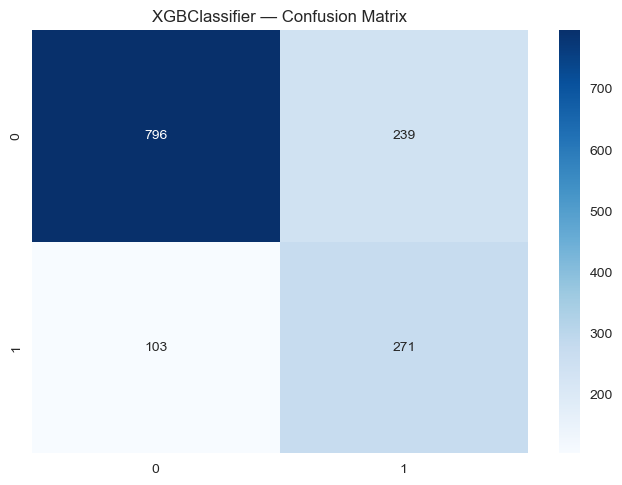

In [ ]:
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
auc_xgb = evaluate_model(xgb, X_train, y_train, X_test, y_test)
    

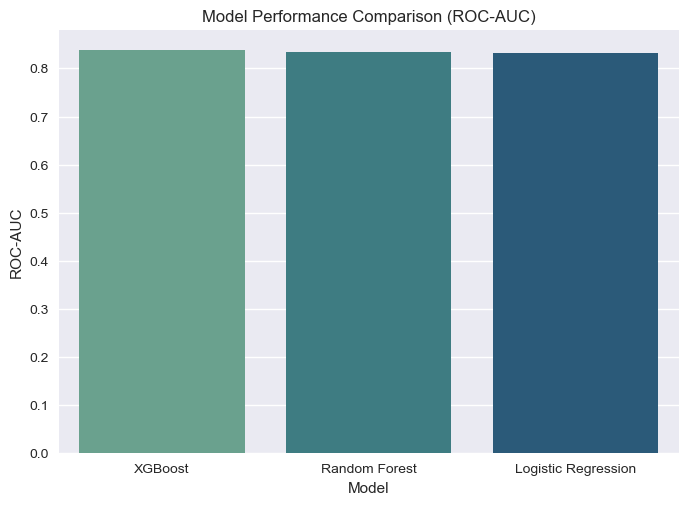

,Model,ROC-AUC
2,XGBoost,0.838312
1,Random Forest,0.834363
0,Logistic Regression,0.831724


In [ ]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'ROC-AUC': [auc_lr, auc_rf, auc_xgb]
}).sort_values(by='ROC-AUC', ascending=False)

sns.barplot(x='Model', y='ROC-AUC', data=results, palette='crest')
plt.title("Model Performance Comparison (ROC-AUC)")
plt.savefig('../reports/figures/model_comparison_roc_auc.png', dpi=200, bbox_inches='tight')
plt.show()

results
    

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Model: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1035
           1       0.62      0.60      0.61       374

    accuracy                           0.80      1409
   macro avg       0.74      0.73      0.74      1409
weighted avg       0.79      0.80      0.80      1409

ROC-AUC: 0.8343


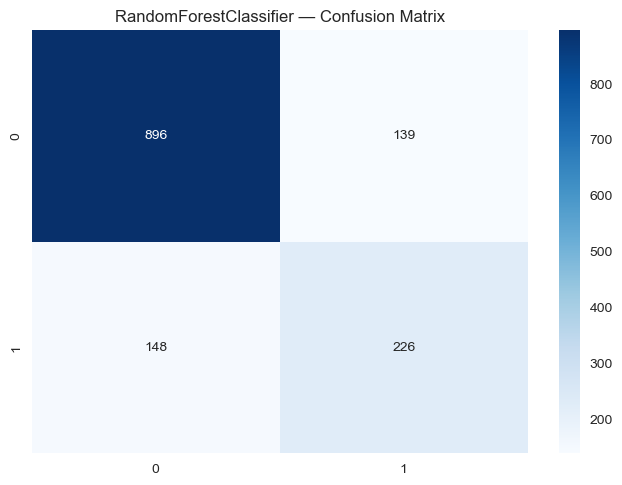

In [9]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid, scoring='roc_auc',
                       cv=3, n_jobs=-1, verbose=1)

grid_rf.fit(X_train, y_train)
print("Best Params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

auc_best_rf = evaluate_model(best_rf, X_train, y_train, X_test, y_test)
    

In [10]:
joblib.dump(best_rf, '../models/best_model.pkl')
print("Best model saved to ../models/best_model.pkl")
    

Best model saved to ../models/best_model.pkl


In [ ]:
summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Tuned RF'],
    'ROC-AUC': [auc_lr, auc_rf, auc_xgb, auc_best_rf]
}).sort_values(by='ROC-AUC', ascending=False)

summary.to_csv('../reports/model_summary.csv', index=False)
summary
    

,Model,ROC-AUC
2,XGBoost,0.838312
1,Random Forest,0.834363
3,Tuned RF,0.834310
0,Logistic Regression,0.831724



### 🧠 Model Insights

| Model | ROC-AUC | Key Takeaway |
|--------|----------|--------------|
| Logistic Regression | 0.831724 | Strong linear baseline |
| Random Forest | 0.834363 | Handles non-linear patterns effectively |
| XGBoost | 0.838312 | Best overall predictive power |
| Tuned Random Forest | 0.834310 | Optimized, suitable for deployment |

**Conclusion:**  
XGBoost or Tuned Random Forest provide the best performance.  
    